In [5]:
# Import necessary libraries
import pandas as pd # for data processing
import numpy as np # here mostly for series generation

import matplotlib.pyplot as plt # for vizualization
import matplotlib.dates as mdates # for data formatting when visualizing
import matplotlib.ticker as ticker # for more advanced axis formatting

import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.vector_ar.vecm import select_order, select_coint_rank, coint_johansen

import statsmodels.api as sm # for linear regression model, OLS estimation
import statsmodels.stats.diagnostic as smd # for Breusch-Godfrey test
from scipy.special.cython_special import betainc

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.api import OLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # ACF, PACF plots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

from IPython.display import Markdown

#import yfinance as yf # for importing data directly from finance.yahoo.com

import warnings
warnings.simplefilter("ignore", category="UserWarning")
warnings.simplefilter("ignore", category="ValueWarning")

# Set global options
pd.options.display.float_format = '{:.10f}'.format
sns.set_theme(style="whitegrid")

In [6]:
data = pd.read_csv('.venv/TSA_project_data.csv', header=0, index_col=0, parse_dates=True, sep=';')

data.drop(columns=['Unnamed: 7', 'Unnamed: 8'], inplace=True)  # drop rolling means as they are not needed for analysis

TypeError: issubclass() arg 2 must be a class, a tuple of classes, or a union

Exception ignored in: 'pandas._libs.tslibs.parsing._maybe_warn_about_dayfirst'
Traceback (most recent call last):
  File "/Users/joannamisiak/Desktop/STUDIA/Time Series Analysis/TSA_project/.venv/lib/python3.13/site-packages/pandas/core/tools/datetimes.py", line 131, in _guess_datetime_format_for_array
    guessed_format = guess_datetime_format(
TypeError: issubclass() arg 2 must be a class, a tuple of classes, or a union


In [7]:
data.head()

,mortgage_world,rates_world,mortgage_US,rates_US,mortgage_Poland,rates_Poland
Date,,,,,,
2020-05-24,81,11,82,7,32,0
2020-05-31,80,12,80,7,38,11
2020-06-07,85,12,84,8,39,11
2020-06-14,85,11,91,7,37,12
2020-06-21,85,11,83,7,44,0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 262 entries, 2020-05-24 to 2025-05-25
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   mortgage_world   262 non-null    int64
 1   rates_world      262 non-null    int64
 2   mortgage_US      262 non-null    int64
 3   rates_US         262 non-null    int64
 4   mortgage_Poland  262 non-null    int64
 5   rates_Poland     262 non-null    int64
dtypes: int64(6)
memory usage: 14.3 KB


In [9]:
data.describe()

,mortgage_world,rates_world,mortgage_US,rates_US,mortgage_Poland,rates_Poland
count,262.0000000000,262.0000000000,262.0000000000,262.0000000000,262.0000000000,262.0000000000
mean,63.7290076336,13.7442748092,67.4618320611,9.9541984733,57.9045801527,15.4770992366
std,9.3950666809,3.7630317179,9.6682753954,3.7228971445,17.3192487542,10.8057318753
min,40.0000000000,7.0000000000,40.0000000000,4.0000000000,25.0000000000,0.0000000000
25%,58.0000000000,11.0000000000,61.2500000000,7.0000000000,45.2500000000,9.5000000000
50%,62.0000000000,14.0000000000,66.0000000000,10.0000000000,53.0000000000,17.0000000000
75%,68.0000000000,16.0000000000,73.0000000000,12.0000000000,71.0000000000,22.7500000000
max,100.0000000000,30.0000000000,100.0000000000,31.0000000000,100.0000000000,53.0000000000


In [53]:
forecast_horizon = 6
data_short = data.iloc[:-forecast_horizon]

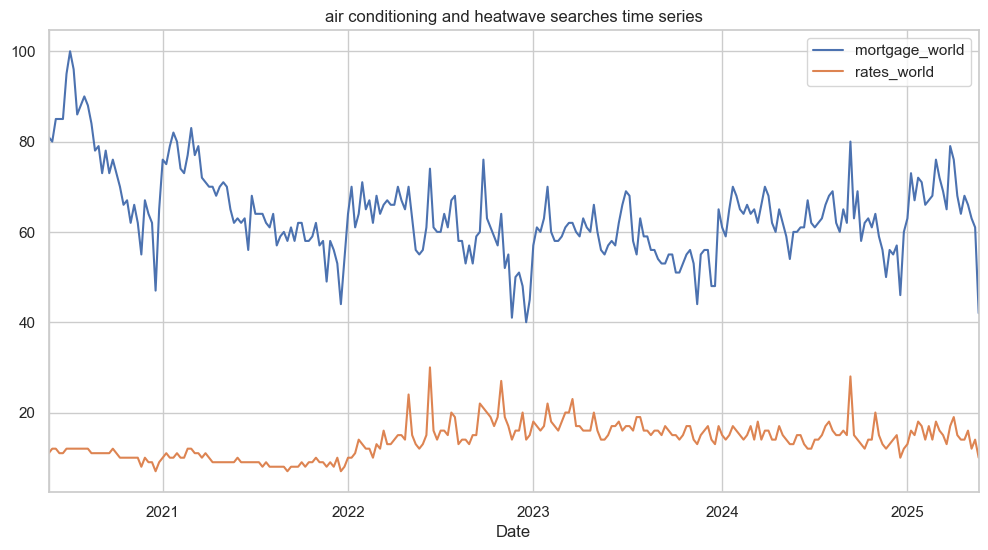

In [54]:
data[['mortgage_world', 'rates_world']].plot(figsize=(12, 6), title='air conditioning and heatwave searches time series')
plt.show()

In [55]:
data['d_mortgage_world'] = data['mortgage_world'].diff()
data['d_rates_world'] = data['rates_world'].diff()

In [56]:
def adf_test(series, max_aug=10, version='c'):

    results = []

    y = series.diff()
    X = pd.DataFrame({'y_lag': series.shift()})

    if version == 'c' or version == 't': # constant to be added optionally
        X = sm.add_constant(X)
    if version == 't': # (deterministic) trend component to be added optionally
        X['trend'] = range(len(X))

    for i in range(0, max_aug): # iterating through different numbers of augmentations

        for aug in range(1, i+1): # adding augmentations max_aug is reached
            X['aug_'+str(aug)] = y.shift(aug)

        model = sm.OLS(series.diff(), X, missing='drop').fit() # fitting a linear regression with OLS

        ts = model.tvalues['y_lag'] # test statistic
        nobs = model.nobs # number of observations

        if version == 'n': # critical values for basic version of ADF
            if nobs > 100:
                cv01 = -2.567; cv05 = -1.941; cv10 = -1.616 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 'c': # critical values for version with constant
            if nobs > 100:
                cv01 = -3.434; cv05 = -2.863; cv10 = -2.568 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 't': # critical values for version with constant and (deterministic) trend component
            if nobs > 100:
                cv01 = -3.963; cv05 = -3.413; cv10 = -3.128 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually

        bg_test01 = smd.acorr_breusch_godfrey(model, nlags=1);  bg_pvalue01 = round(bg_test01[1],4); bg_test01 = round(bg_test01[0],4);
        bg_test05 = smd.acorr_breusch_godfrey(model, nlags=5);  bg_pvalue05 = round(bg_test05[1],4); bg_test05 = round(bg_test05[0],4);
        bg_test10 = smd.acorr_breusch_godfrey(model, nlags=10); bg_pvalue10 = round(bg_test10[1],4); bg_test10 = round(bg_test10[0],4);
        bg_test15 = smd.acorr_breusch_godfrey(model, nlags=15); bg_pvalue15 = round(bg_test15[1],4); bg_test15 = round(bg_test15[0],4);

        results.append([i, ts, cv01, cv05, cv10,
                        bg_test01, bg_pvalue01, bg_test05, bg_pvalue05, bg_test10, bg_pvalue10, bg_test15, bg_pvalue15])

    results_df = pd.DataFrame(results)
    results_df.columns = ['number of augmentations',
                          'ADF test statistic', 'ADF critival value (1%)', 'ADF critival value (5%)', 'ADF critival value (10%)',
                          'BG test (1 lag) (statistic)', 'BG test (1 lag) (p-value)',
                          'BG test (5 lags) (statistic)', 'BG test (5 lags) (p-value)',
                          'BG test (10 lags) (statistic)', 'BG test (10 lags) (p-value)',
                          'BG test (15 lags) (statistic)', 'BG test (15 lags) (p-value)']

    return results_df



In [57]:
adf_test(data['mortgage_world'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-5.0798755533,-3.4340000000,-2.8630000000,-2.5680000000,9.0250000000,0.0027000000,28.6168000000,0.0000000000,40.2341000000,0.0000000000,54.3936000000,0.0000000000
1,1,-4.0621764783,-3.4340000000,-2.8630000000,-2.5680000000,0.8438000000,0.3583000000,20.8780000000,0.0009000000,31.0291000000,0.0006000000,46.4080000000,0.0000000000
2,2,-3.9262688208,-3.4340000000,-2.8630000000,-2.5680000000,6.4410000000,0.0112000000,19.0163000000,0.0019000000,31.0283000000,0.0006000000,46.8120000000,0.0000000000
3,3,-3.2052000726,-3.4340000000,-2.8630000000,-2.5680000000,1.3516000000,0.2450000000,11.4542000000,0.0431000000,26.0777000000,0.0036000000,34.4241000000,0.0030000000
4,4,-3.4185665204,-3.4340000000,-2.8630000000,-2.5680000000,9.1292000000,0.0025000000,18.0741000000,0.0029000000,24.5150000000,0.0063000000,36.0959000000,0.0017000000
5,5,-4.1412270465,-3.4340000000,-2.8630000000,-2.5680000000,1.3799000000,0.2401000000,7.4764000000,0.1876000000,12.8519000000,0.2321000000,26.2284000000,0.0357000000
6,6,-4.2444444814,-3.4340000000,-2.8630000000,-2.5680000000,0.0262000000,0.8715000000,4.9219000000,0.4255000000,21.4692000000,0.0180000000,22.8668000000,0.0870000000
7,7,-4.4151304844,-3.4340000000,-2.8630000000,-2.5680000000,0.2768000000,0.5988000000,7.4592000000,0.1887000000,19.8674000000,0.0305000000,20.5111000000,0.1532000000
8,8,-4.0974596273,-3.4340000000,-2.8630000000,-2.5680000000,3.0051000000,0.0830000000,8.6940000000,0.1219000000,18.0422000000,0.0543000000,19.1878000000,0.2053000000
9,9,-4.3593161273,-3.4340000000,-2.8630000000,-2.5680000000,0.5914000000,0.4419000000,10.4080000000,0.0645000000,14.8680000000,0.1369000000,19.4022000000,0.1961000000


In [59]:
adf_test(data['rates_world'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-6.3648905215,-3.4340000000,-2.8630000000,-2.5680000000,17.5037000000,0.0000000000,59.7233000000,0.0000000000,68.4010000000,0.0000000000,79.3090000000,0.0000000000
1,1,-4.5193851780,-3.4340000000,-2.8630000000,-2.5680000000,7.0792000000,0.0078000000,50.1388000000,0.0000000000,55.0106000000,0.0000000000,67.1095000000,0.0000000000
2,2,-3.6677302587,-3.4340000000,-2.8630000000,-2.5680000000,12.7423000000,0.0004000000,44.5298000000,0.0000000000,49.4944000000,0.0000000000,61.8447000000,0.0000000000
3,3,-2.8718245249,-3.4340000000,-2.8630000000,-2.5680000000,10.6749000000,0.0011000000,34.5632000000,0.0000000000,40.5234000000,0.0000000000,50.9852000000,0.0000000000
4,4,-2.3178563107,-3.4340000000,-2.8630000000,-2.5680000000,22.7119000000,0.0000000000,27.4785000000,0.0000000000,39.0219000000,0.0000000000,44.0568000000,0.0001000000
5,5,-1.7027941042,-3.4340000000,-2.8630000000,-2.5680000000,0.3846000000,0.5352000000,5.6169000000,0.3453000000,21.1635000000,0.0200000000,26.0084000000,0.0379000000
6,6,-1.6233546529,-3.4340000000,-2.8630000000,-2.5680000000,2.0379000000,0.1534000000,5.2084000000,0.3910000000,20.5690000000,0.0243000000,26.4987000000,0.0331000000
7,7,-1.7485483338,-3.4340000000,-2.8630000000,-2.5680000000,0.5160000000,0.4726000000,13.9881000000,0.0157000000,20.0546000000,0.0287000000,31.1296000000,0.0084000000
8,8,-1.6610009609,-3.4340000000,-2.8630000000,-2.5680000000,2.4865000000,0.1148000000,13.6001000000,0.0184000000,20.0782000000,0.0285000000,37.9080000000,0.0009000000
9,9,-1.7977767124,-3.4340000000,-2.8630000000,-2.5680000000,0.2127000000,0.6447000000,16.1542000000,0.0064000000,20.2226000000,0.0272000000,37.5735000000,0.0010000000


In [60]:
adf_test(data['d_rates_world'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-23.3265777949,-3.4340000000,-2.8630000000,-2.5680000000,13.3437000000,0.0003000000,63.4038000000,0.0000000000,67.5941000000,0.0000000000,80.4902000000,0.0000000000
1,1,-16.5853368096,-3.4340000000,-2.8630000000,-2.5680000000,17.4084000000,0.0000000000,53.8753000000,0.0000000000,57.9831000000,0.0000000000,70.5249000000,0.0000000000
2,2,-14.9230703897,-3.4340000000,-2.8630000000,-2.5680000000,13.3623000000,0.0003000000,39.4801000000,0.0000000000,46.1325000000,0.0000000000,55.8988000000,0.0000000000
3,3,-13.6550088171,-3.4340000000,-2.8630000000,-2.5680000000,25.0435000000,0.0000000000,29.4408000000,0.0000000000,42.9816000000,0.0000000000,47.3853000000,0.0000000000
4,4,-14.2372929929,-3.4340000000,-2.8630000000,-2.5680000000,0.6192000000,0.4313000000,4.9727000000,0.4192000000,22.1225000000,0.0145000000,27.1896000000,0.0272000000
5,5,-11.0156675970,-3.4340000000,-2.8630000000,-2.5680000000,1.5150000000,0.2184000000,4.4724000000,0.4836000000,21.2745000000,0.0193000000,27.4682000000,0.0251000000
6,6,-8.1613803280,-3.4340000000,-2.8630000000,-2.5680000000,0.7897000000,0.3742000000,4.7994000000,0.4409000000,20.8012000000,0.0225000000,30.4185000000,0.0105000000
7,7,-7.5545162496,-3.4340000000,-2.8630000000,-2.5680000000,1.9115000000,0.1668000000,14.4223000000,0.0131000000,21.1052000000,0.0204000000,37.3507000000,0.0011000000
8,8,-6.1540201961,-3.4340000000,-2.8630000000,-2.5680000000,0.0740000000,0.7855000000,17.2567000000,0.0040000000,19.4049000000,0.0354000000,38.7745000000,0.0007000000
9,9,-5.5780268323,-3.4340000000,-2.8630000000,-2.5680000000,1.3525000000,0.2448000000,17.3666000000,0.0039000000,23.6205000000,0.0087000000,39.2532000000,0.0006000000


In [61]:
grangercausalitytests(data[['mortgage_world', 'rates_world']].dropna(), maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.0589 , p=0.0001  , df_denom=258, df_num=1
ssr based chi2 test:   chi2=16.2456 , p=0.0001  , df=1
likelihood ratio test: chi2=15.7601 , p=0.0001  , df=1
parameter F test:         F=16.0589 , p=0.0001  , df_denom=258, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.9259  , p=0.0031  , df_denom=255, df_num=2
ssr based chi2 test:   chi2=12.0842 , p=0.0024  , df=2
likelihood ratio test: chi2=11.8118 , p=0.0027  , df=2
parameter F test:         F=5.9259  , p=0.0031  , df_denom=255, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.7136  , p=0.0121  , df_denom=252, df_num=3
ssr based chi2 test:   chi2=11.4501 , p=0.0095  , df=3
likelihood ratio test: chi2=11.2043 , p=0.0107  , df=3
parameter F test:         F=3.7136  , p=0.0121  , df_denom=252, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.5214  , p=0.0417  

{np.int64(1): ({'ssr_ftest': (np.float64(16.058867922720996),
    np.float64(8.039873144363321e-05),
    np.float64(258.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(16.245598945078218),
    np.float64(5.563868812212872e-05),
    np.int64(1)),
   'lrtest': (np.float64(15.760052998947003),
    np.float64(7.190481768364763e-05),
    np.int64(1)),
   'params_ftest': (np.float64(16.058867922721184),
    np.float64(8.039873144362547e-05),
    np.float64(258.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(5.9259128885065975),
    np.float64(0.0030508807985175647),
    np.float64(255.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(12.084214517738944),
    np.float64(0.002376545636464492),
    np.int64(2)),
   'lrtest': (np.float64(11.811799885099163),
    np.float64(0.0027233298371985497),
    np.int64(2)),
   'params_ftest': (np.float64(5.925912888506541),
    np.float64(0.0030508807985177456),
    np.float64(255.0),
    2.0)},
   array([[0., 0

We reject the null hypothesis of no causalty at the 5% significance level for lags 1, 2, 3, 4, 5. This means that `rates` Granger causes `mortgage` at the 5% significance level. Hence, we can conclude that `rates` is a Granger cause of  `mortgage`.

In [62]:
grangercausalitytests(data[['rates_world', 'mortgage_world']].dropna(), maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.3008 , p=0.0015  , df_denom=258, df_num=1
ssr based chi2 test:   chi2=10.4205 , p=0.0012  , df=1
likelihood ratio test: chi2=10.2179 , p=0.0014  , df=1
parameter F test:         F=10.3008 , p=0.0015  , df_denom=258, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.5150  , p=0.0118  , df_denom=255, df_num=2
ssr based chi2 test:   chi2=9.2070  , p=0.0100  , df=2
likelihood ratio test: chi2=9.0477  , p=0.0108  , df=2
parameter F test:         F=4.5150  , p=0.0118  , df_denom=255, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.9391  , p=0.0338  , df_denom=252, df_num=3
ssr based chi2 test:   chi2=9.0622  , p=0.0285  , df=3
likelihood ratio test: chi2=8.9073  , p=0.0305  , df=3
parameter F test:         F=2.9391  , p=0.0338  , df_denom=252, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7220  , p=0.1456  

{np.int64(1): ({'ssr_ftest': (np.float64(10.30076520388854),
    np.float64(0.0014980953180058266),
    np.float64(258.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(10.42054154346864),
    np.float64(0.001246213455219387),
    np.int64(1)),
   'lrtest': (np.float64(10.2178954079925),
    np.float64(0.0013908447127871121),
    np.int64(1)),
   'params_ftest': (np.float64(10.3007652038913),
    np.float64(0.0014980953180036972),
    np.float64(258.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(4.514976998394101),
    np.float64(0.011832867457575424),
    np.float64(255.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(9.207011918293853),
    np.float64(0.010016656124351951),
    np.int64(2)),
   'lrtest': (np.float64(9.047743551755502),
    np.float64(0.010846945320913093),
    np.int64(2)),
   'params_ftest': (np.float64(4.5149769983940695),
    np.float64(0.011832867457575773),
    np.float64(255.0),
    2.0)},
   array([[0., 0., 1., 0., 0

We reject the null hypothesis of no causalty at the 5% significance level for lags 1, 2, 3. This means that `mortgage` Granger causes `rates` at the 5% significance level. Hence, we can conclude that `mortgage` is a Granger cause of  `rates`.

In [64]:
model = VAR(data, freq='W')
results = model.select_order(maxlags=15)
print("\nLag selection results:")
print(results.summary())

LinAlgError: 7-th leading minor of the array is not positive definite